#cambio y aplicar cambios en VM

# Título  gbtd con semillero y envío 
## Autor: Jose Chelquer
## Fecha de última modificación: 29/11/2024

Carga el modelo optimizado, evalúa y envía



## Parámetros

< Descripción de cada uno de los parámetros que utiliza el job >


In [1]:
prueba=False                     # temporario. Volver a false

semillero=True
n_semillas = 10

experimento="_pcf"                   
tipo_registros=experimento[0]            # '_'completo s sampleado
con_preprocesamiento = experimento[1]    # p con preprocesamiento  '_' sin preprocesamiento
tipo_featuring=experimento[2]            # _: 155 base  s: simple    c: completo
rf=experimento[3]                        # _: sin RF   r: con RF

dict_tipo_registros={'_': 'completo', 's': 'sampleado'}
dict_con_preprocesamiento={'_': 'sin preprocesamiento', 'p':'con preprocesamiento'}
dict_tipo_featuring={'_': 'base', 's':' simple', 'c': 'completo'}
dict_rf={'_': 'sin RF', 'f':' con RF'}

print (f'Experimento {experimento}')
print (dict_tipo_registros[tipo_registros])
print (dict_con_preprocesamiento[con_preprocesamiento])
print (dict_tipo_featuring[tipo_featuring])
print (dict_rf[rf])


Experimento _psf
completo
con preprocesamiento
 simple
 con RF


In [2]:
# vm o local?
vm=True
if vm:
  usar_gdrive=False
else:
  usar_gdrive=True      #se va a usar google dirve


In [3]:
semillas=[101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197]

ganancia_acierto=273000
costo_estimulo=7000

In [4]:
# meses de entrenamiento, evaluación y test
if vm:
  mes_train_desde = 202101
  mes_train_hasta = 202106
  mes_eval=202107
  mes_test = 202109
else:
  mes_train_desde = 202104
  mes_train_hasta = 202106
  mes_eval=202107
  mes_test = 202109

In [5]:

grabar_importancias=False          # Se puede pedir que grabe las importancias de variables como resultado secundario
importancias_file=f'importancias_lgb{experimento}.csv.gz'


In [6]:
# parámetros de envío a kaggle
version = f'210_{experimento}_'
prefijo_envio=f"j010_lgb_{experimento}_"
enviar_desde=7000
enviar_hasta=16000
cant_envios=10            #Cantidad de envíos a Kaggle

# para prueba
#enviar_desde=12000
#enviar_hasta=12000
#cant_envios=2            #Cantidad de envíos a Kaggle


## Input

< Archivos de datos (csv.gz) con sus paths que van a consumirse por el job>

In [7]:
if vm:
  dataset_path = '/home/jose/buckets/b1/datasets'
  kaggle_json_path="/home/jose/buckets/b1"
  if prueba:
      dataset_file="k3_fe.parquet.gz"
  else:
      dataset_file=f"k3_{tipo_registros}{con_preprocesamiento}{tipo_featuring}{rf}.parquet.gz"
else:
  dataset_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/datasets/'
  kaggle_json_path="/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas"

  sufijo=''
  if dset=="rf":
    sufijo='_cRF'
  infijo='_base'
  if feat=="aum":
    infijo='_aum'

  dataset_file=f"sample_c02{infijo}_m1a8{sufijo}.csv.gz"

print (dataset_path)
print (dataset_file)

/home/jose/buckets/b1/datasets
k3__psf.parquet.gz


In [8]:
if vm:
  db_path='/home/jose/buckets/b1/db'
  modelos_path='/home/jose/buckets/b1/modelos'

else:
  db_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/db/'
        # optuna no puede hacerlo en drive.  La copia se hará al final, si se puede
  modelos_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/modelos/'

modelos_file=f'lgb_optimizado_final_{experimento}'
print (f'Se va a usar el modelo {modelos_file}')
import os
path_modelo=os.path.join(modelos_path, modelos_file)+".txt"
print (f'Path del modelo: {path_modelo}')
print ('-------------------------------')
print ('controlar que sea el optimizado')
print ('-------------------------------')

params_file=f'{experimento}_combined_params.json'

Se va a usar el modelo lgb_optimizado_final__psf
Path del modelo: /home/jose/buckets/b1/modelos/lgb_optimizado_final__psf.txt
-------------------------------
controlar que sea el optimizado
-------------------------------


## Output

< Archivos, bases de datos, modelos que va a generar el job>

## Procesos

### Paquetes necesarios

## Código del proceso

< Todo el código a partir de aquí debe poder ejecutarse sin necesidad de parametrizar nada>

Instalamos, cargamos y seteamos el entorno

## Gdrive?

In [9]:
if usar_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

## Librerías

In [10]:
!pip install --upgrade pip
!pip install --upgrade lightgbm
!pip install dask[dataframe]

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


import json

from time import time

import pickle



In [12]:
import lightgbm as lgb

## Funciones útiles varias

In [13]:
def buscar_columnas(data, texto):
    # devuelve los nombre de cols de data que contengan texto
    # Encuentra las columnas que contienen el texto
    columnas_filtradas = [col for col in data.columns if texto in col]
    
    # Imprime las columnas que coinciden
    return columnas_filtradas

## Leer datos

In [14]:
semilla=semillas[2]


In [15]:
def contabilizar(df, descripción):
  print (f'\nContabilización de la base {descripción}\n')
  print (f'\nShape: {df.shape}\n')
  n_vars=len(df.columns)
  n_vars_tree=len([col for col in df.columns if col.startswith('tree')])
  print (f"Variables: {n_vars}")
  print (f"Variables tree: {n_vars_tree}")
  print (f"\nFilas por mes: \n{df['foto_mes'].value_counts()}\n")
  if 'clase_ternaria' in df.columns:
    print (f"\nFilas por mes y clase: \n{pd.crosstab(df['foto_mes'], df['clase_ternaria'])}\n")
def cant_meses(df):
  return len(df['foto_mes'].unique())

In [16]:
if 'parquet' in dataset_file:
    data = pd.read_parquet(os.path.join(dataset_path, dataset_file))
else:
    data = pd.read_csv(os.path.join(dataset_path, dataset_file))
if 'clase_ternaria_num' in data.columns:
  data = data.drop(columns=['clase_ternaria_num'])

In [17]:
data = data.sort_values(by=['foto_mes', 'numero_de_cliente'])


In [18]:
data.loc[data['foto_mes']==mes_test, 'numero_de_cliente'].head(10)

234381     249221109
703406     249221468
4141563    249223005
1987915    249232117
2634530    249236712
2849942    249236857
3518403    249237079
3564624    249237446
2397374    249239632
3471378    249242331
Name: numero_de_cliente, dtype: int64

In [19]:

contabilizar(data, 'Datos Leídos '+ dataset_file)


Contabilización de la base Datos Leídos k3__psf.parquet.gz


Shape: (4901237, 1097)

Variables: 1097
Variables tree: 320

Filas por mes: 
foto_mes
202109    165644
202108    165442
202107    165152
202106    164876
202105    164623
202104    164090
202103    163685
202102    162646
202101    162026
202012    161526
202011    160742
202010    159731
202009    158371
202008    157058
202007    155764
202006    153757
202005    151261
202004    149872
202003    149356
202002    147109
202001    143966
201912    140661
201911    138667
201910    136682
201909    134314
201908    132664
201907    130724
201906    129186
201905    127659
201904    126996
201903    126436
201902    125799
201901    124752
Name: count, dtype: int64


Filas por mes y clase: 
clase_ternaria  BAJA+1  BAJA+2  CONTINUA
foto_mes                                
201901             688     718    123346
201902             720     688    124391
201903             688     760    124988
201904             759     579    

# ------------------------------------------------------------------
# Eliminado aquí a último momento para probar
# ------------------------------------------------------------------


In [20]:
# eliminar selectivamente variables
data = data.loc[:, ~data.columns.str.contains('prestamos_personales', case=False)]
data = data.loc[:, ~data.columns.str.contains('ultimo_cierre', case=False)]
print (f"Nueva cantidad de columnas {len(data.columns)}")

Nueva cantidad de columnas 1097


In [21]:
# FIN DEL AGREGADO DE ULTIMO MOMENTO

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


## Recodificar clase ternaria

In [22]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [23]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

## Preparar train y test

In [24]:
train_data = data[(data['foto_mes'] >= mes_train_desde)&(data['foto_mes'] <= mes_train_hasta)]
test_data = data[data['foto_mes'] == mes_test]
eval_data = data[data['foto_mes'] == mes_eval]

print ("Armando X_train")
print ("Separando X_train y_train etc.")
X_train = train_data.drop(['clase_ternaria','clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']
y_train = y_train_binaria2

print ("Armando X_eval")
X_eval = eval_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_eval_binaria1 = eval_data['clase_binaria1']
y_eval_binaria2 = eval_data['clase_binaria2']
w_eval = eval_data['clase_peso']

print ("Armando X_test")
X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test= test_data['clase_binaria2']
w_test = test_data['clase_peso']
print ("listo")

contabilizar(X_eval, 'datos de evaluación')
contabilizar(X_test, 'datos de test')


Armando X_train
Separando X_train y_train etc.
Armando X_eval
Armando X_test
listo

Contabilización de la base datos de evaluación


Shape: (165152, 1093)

Variables: 1093
Variables tree: 320

Filas por mes: 
foto_mes
202107    165152
Name: count, dtype: int64


Contabilización de la base datos de test


Shape: (165644, 1093)

Variables: 1093
Variables tree: 320

Filas por mes: 
foto_mes
202109    165644
Name: count, dtype: int64



In [25]:
# Para calcular ganancias fuera del proceso de optimización:
def ganancias_obtenidas(y_pred, X, weight):
    n_meses=cant_meses(X)
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]] #: desde todo : hasta todo :-1 step hacia atrás
    # Ganancias acumuladas so far
    print (ganancia)
    
    ganancia_acum = np.cumsum(ganancia)
    print (ganancia_acum)
    ganancia_maxima=max(ganancia_acum)
    cant_envios = np.argmax(ganancia_acum) + 1  # Sumar 1 para tener la posición en términos de "cantidad"

    return np.round(ganancia_acum/n_meses/1000), np.round(ganancia_maxima/n_meses/1000), cant_envios



## Recuperación de best params

In [26]:
# Entreno con el mejor modelo
# Ruta al archivo JSON con los mejores parámetros
input_path = os.path.join(modelos_path, params_file)
print (f'leyendo {input_path}')
# Cargar los parámetros desde el archivo
with open(input_path, "r") as file:
    params_con_rounds = json.load(file)

num_boost_round= params_con_rounds['num_boost_round']
combined_params=params_con_rounds
del  combined_params['num_boost_round']
print("Num_boost_round:", num_boost_round)
print("Parámetros cargados:", combined_params)



leyendo /home/jose/buckets/b1/modelos/_psf_combined_params.json
Num_boost_round: 360
Parámetros cargados: {'num_leaves': 156, 'learning_rate': 0.03356010386318363, 'min_data_in_leaf': 14, 'feature_fraction': 0.7484330614229726, 'bagging_fraction': 0.02299407577995452, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'max_bin': 31, 'verbosity': -1}


## Cargar el modelo

In [27]:

print (path_modelo)
model = lgb.Booster(model_file=os.path.join(modelos_path, modelos_file)+'.txt')

/home/jose/buckets/b1/modelos/lgb_optimizado_final__psf.txt


In [28]:
mes_test

202109

# Resultados de entrenamiento

In [29]:

y_pred_eval=model.predict(X_eval)

ganancias_eval, gmax_eval, envios_eval=ganancias_obtenidas(y_pred_eval, X_eval, w_eval)
print (f"Ganancia máxima en eval: {gmax_eval}\n")
print (f"Envíos para ganancia máxima: {envios_eval}\n")
print (f"Ganancias en eval: {ganancias_eval}")

[-7000 -7000 -7000 ... -7000 -7000 -7000]
[     -7000     -14000     -21000 ... -793730000 -793737000 -793744000]
Ganancia máxima en eval: 161427.0

Envíos para ganancia máxima: 11659

Ganancias en eval: [-7.00000e+00 -1.40000e+01 -2.10000e+01 ... -7.93730e+05 -7.93737e+05
 -7.93744e+05]


In [30]:
def resultados_modelo(model, feature_names):
  importances = model.feature_importance()
  importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
  importance_df = importance_df.sort_values('importance', ascending=False)
  importance_df[importance_df['importance'] > 0]

  print(importance_df.head(20))

  if grabar_importancias:
      if importancias_file.endswith('.gz'):
        importance_df.to_csv(os.path.join(dataset_path,  importancias_file), index=False, compression='gzip')
      else:
        importance_df.to_csv(os.path.join(dataset_path,  importancias_file), index=False)
resultados_modelo(model, X_test.columns.tolist())

                        feature  importance
0             numero_de_cliente         506
272   mrentabilidad_annual_lag2         373
5                  cliente_edad         366
12                   cproductos         320
70    mcomisiones_mantenimiento         305
266           cliente_edad_lag2         305
10              mactivos_margen         299
16            mcuenta_corriente         294
110         Master_Fvencimiento         291
476    Master_Fvencimiento_lag2         287
475    Master_Fvencimiento_lag1         281
95   chomebanking_transacciones         273
105                ctrx_quarter         271
271   mrentabilidad_annual_lag1         255
1                      foto_mes         253
6            cliente_antiguedad         248
22               mcuentas_saldo         247
514      Visa_Fvencimiento_lag2         246
265           cliente_edad_lag1         241
287      mcuenta_corriente_lag1         240


In [31]:
print (y_pred_eval)

[0.00681562 0.00543632 0.00012355 ... 0.00477078 0.00621942 0.01364119]


## Para Kaggle



In [32]:
def enviar_kaggle(y_pred_test, X_test):
  # Cargo el kaggle.json para poder conectarme
  # Mueve kaggle.json al directorio correcto
 if not vm:
      os.makedirs('/root/.kaggle', exist_ok=True)
      shutil.copy(f'{kaggle_json_path}/kaggle.json', '/root/.kaggle/kaggle.json')
      os.chmod('/root/.kaggle/kaggle.json', 600)
  # Obtengo el orden de prioridad para el envío
    
 idx_deseables=np.argsort(y_pred_test)[::-1]
    # ------------------------------------------------------------------
  # Los topes de envíos se determinaron al hacer la curva en eval
 for envios in np.linspace(enviar_desde, enviar_hasta, cant_envios, dtype=int):
      print (f"Enviando: {envios}")
      # Notar que idx_deseables tiene índices de y_pred (de 0 al máximo de línes de y_pred)

      # los primeros envíos irán con predicción 1 y el resto 0
      # idx_deseables contiene los índices de y_pred (no los originales!!) cuyas predicciones tienen los mejores valores, en orden desdendente
      # guardo en elegidos los índices de los datos correspondientes a los primeros :envios en idx
      elegidos=X_test.index[idx_deseables[:envios]]

      # Creo clientes_kaggle sólo con el número de cliente de  X_test
      clientes_kaggle=X_test.loc[:, ['numero_de_cliente']].copy()
      clientes_kaggle['Predicted']=0    #default
      clientes_kaggle.loc[elegidos, 'Predicted'] = 1   # marco los "enviados"
      if clientes_kaggle.shape != ( 165644, 2):
          raise ValueError(f"El DataFrame 'clientes_enviados' no tiene la forma esperada. Forma actual: {clientes_kaggle.shape}")
      else:
          print("La forma de 'clientes_enviados' es correcta.")

          # elijo el nombre para el archivo enviar, para llevar control
          # un mensaje para registrar
          # y me grabo el archivo que mando para tener control local
    
          # Voy a mandar con un mensaje que incluya los parámetros usados y la cantidad de envíos
          mensaje=f"lgbm aumentada semillero {combined_params} {envios}"
          # # Me gusta guardar los envíos que hago
          archivo=f'{prefijo_envio}-v_{version}-{envios}.csv'
          import os 
          path_archivo=os.path.join(dataset_path,archivo)
          clientes_kaggle.to_csv(path_archivo, index=False)
    
          # Envío a la competencia
          competencia="dm-ey-f-2024-tercera"
          !kaggle competitions submit -c {competencia} -f '{path_archivo}' -m '{mensaje}'

 params_str = str(combined_params)

 # Eliminar llaves {}, apóstrofes ' y dos puntos :
 params_str = params_str.replace('{', '').replace('}', '').replace("'", '').replace(':', '').replace(",",'')
 print (params_str)

 print (clientes_kaggle)



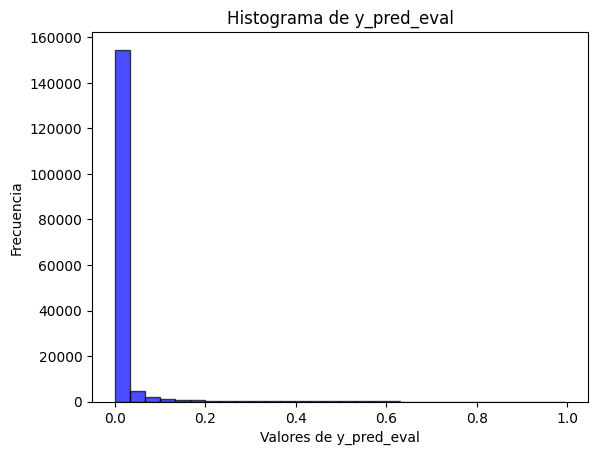

In [33]:
# Suponiendo que y_pred_eval es un array o lista
plt.hist(y_pred_eval, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma de y_pred_eval')
plt.xlabel('Valores de y_pred_eval')
plt.ylabel('Frecuencia')
plt.show()

## Predecir con o sin semillero

In [34]:
def semillerio(X, semillas, n_semillas):
    print ('Parámetros combinados')
    train_data = lgb.Dataset(X_train,
                          label=y_train,
                          weight=w_train)
    semillas_a_usar=semillas[:n_semillas-1]
    resultados = []  # Lista para almacenar los resultados

    for semilla in semillas_a_usar:
        print("Optimizando con semilla", semilla)
        combined_params['seed'] = semilla
        
        # Entrenar el modelo con la semilla actual
        model = lgb.train(
            combined_params,
            train_set=train_data,
            num_boost_round=num_boost_round
        )
        print (X.shape)
        
        print("Prediciendo")
        # Obtener predicciones y guardarlas
        y_pred = model.predict(X)
        resultados.append(y_pred)
    
    # Promediar los resultados al final
    resultado_promedio = sum(resultados) / len(resultados)
    
    # Retornar el resultado promedio
    print("Resultado promedio:", resultado_promedio)
    return resultado_promedio


In [35]:
if semillero:
    y_pred_test=semillerio(X_test, semillas, n_semillas)
else:
    y_pred_test=model.predict(X_test)
    
                        

Parámetros combinados
Optimizando con semilla 101
(165644, 1093)
Prediciendo
Optimizando con semilla 103
(165644, 1093)
Prediciendo
Optimizando con semilla 107
(165644, 1093)
Prediciendo
Optimizando con semilla 109
(165644, 1093)
Prediciendo
Optimizando con semilla 113
(165644, 1093)
Prediciendo
Optimizando con semilla 127
(165644, 1093)
Prediciendo
Optimizando con semilla 131
(165644, 1093)
Prediciendo
Optimizando con semilla 137
(165644, 1093)
Prediciendo
Optimizando con semilla 139
(165644, 1093)
Prediciendo
Resultado promedio: [0.0010636  0.00215639 0.00013887 ... 0.00283485 0.01600721 0.01632858]


In [36]:
np.sort(y_pred_test)[::-1]
#y_pred_test

array([9.08083259e-01, 8.70770817e-01, 8.60292934e-01, ...,
       1.99519829e-05, 1.94468343e-05, 1.87971269e-05])

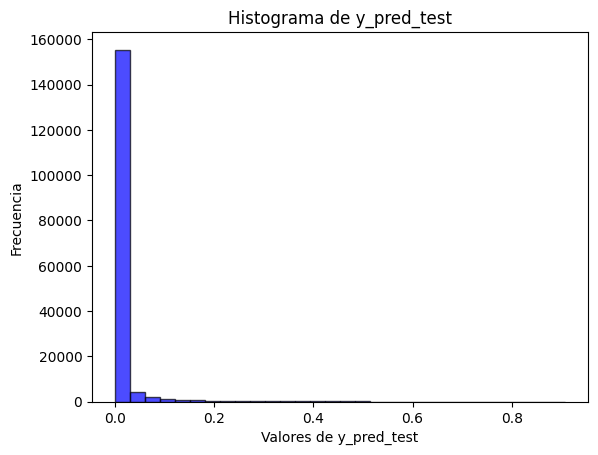

In [37]:
# Suponiendo que y_pred_eval es un array o lista
plt.hist(y_pred_test, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma de y_pred_test')
plt.xlabel('Valores de y_pred_test')
plt.ylabel('Frecuencia')
plt.show()

# ENVIO A KAGGLE

In [38]:
enviar_kaggle(y_pred_test, X_test)

Enviando: 7000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.94M/1.94M [00:00<00:00, 3.01MB/s]
Successfully submitted to DMEyF 2024 TerceraEnviando: 8000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.94M/1.94M [00:00<00:00, 3.18MB/s]
Successfully submitted to DMEyF 2024 TerceraEnviando: 9000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.94M/1.94M [00:00<00:00, 3.31MB/s]
Successfully submitted to DMEyF 2024 TerceraEnviando: 10000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.94M/1.94M [00:00<00:00, 3.28MB/s]
Successfully submitted to DMEyF 2024 TerceraEnviando: 11000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.94M/1.94M [00:00<00:00, 3.20MB/s]
Successfully submitted to DMEyF 2024 TerceraEnviando: 12000
La forma de 'clientes_enviados' es correcta.
100%|███████